# De-convolutional Autoencoder

Import dependencies

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

### Util functions

function to plot the images after during testing phase

In [2]:
def plot_images(images, title, no_i_x, no_i_y=2):
    fig = plt.figure(figsize=(5, 15))
    fig.canvas.set_window_title(title)
    images = np.array(images).reshape(-1, 28, 28)
    for i in range(no_i_x):
        for j in range(no_i_y):
            ax = fig.add_subplot(no_i_x, no_i_y, no_i_x * j + (i + 1))
            ax.matshow(images[no_i_x * j + i], cmap="gray")
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

            if j == 0 and i == 0:
                ax.set_title("Real")
            elif j == 0 and i == 1:
                ax.set_title("Reconstructed")

load the mmist dataset from tensorflow.examples

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Neural Network Model
Encoder = 2 convolutional layers + 1 fully connected layer<br>
Decoder = 2 de-convolutional layers + 1 fully connected layer<br>

<br>Hyper-parameters

In [4]:
n_image_width = 28
n_image_height = 28
n_input_pixels = n_image_height * n_image_width
filter_width = 5
filter_height = 5
n_channels = 1  # black

conv_1_features = 16
conv_2_features = 32

final_hid_lay = 196

learning_rate = 0.001
batch_size = 20

images_to_plot = 10

input placeholder

In [5]:
X = tf.placeholder(tf.float32, [None, n_input_pixels])

Layer Weights and biases

In [6]:
conv_lay_1 = {
    'weight': tf.Variable(tf.random_normal(
            [filter_height, filter_width, n_channels, conv_1_features], stddev=0.1)),
    'bias': tf.Variable(tf.random_normal([conv_1_features], stddev=0.1))
}
conv_lay_2 = {
    'weight': tf.Variable(tf.random_normal(
            [filter_height, filter_width, conv_1_features, conv_2_features], stddev=0.1)),
    'bias': tf.Variable(tf.random_normal([conv_2_features], stddev=0.1))
}
fc_enc_lay_1 = {
    'weight': tf.Variable(tf.random_normal(
            [7 * 7 * conv_2_features, final_hid_lay], stddev=0.1)),
    'bias': tf.Variable(tf.random_normal([final_hid_lay], stddev=0.1))
}

deconv_lay_1 = {
    'weight': tf.Variable(tf.random_normal(
            [filter_height, filter_width, conv_1_features, conv_2_features], stddev=0.1)),
    'bias': tf.Variable(tf.random_normal([conv_1_features], stddev=0.1))
}
deconv_lay_2 = {
    'weight': tf.Variable(tf.random_normal(
            [filter_height, filter_width, n_channels, conv_1_features], stddev=0.1)),
    'bias': tf.Variable(tf.random_normal([n_channels], stddev=0.1))
}
fc_dec_lay_2 = {
    'weight': tf.Variable(tf.random_normal(
            [final_hid_lay, 7 * 7 * conv_2_features], stddev=0.1)),
    'bias': tf.Variable(tf.random_normal([7 * 7 * conv_2_features], stddev=0.1))
}

Encoder -> 2 convoltional layers (without max-pooling)

In [7]:
# Resize image to proper shape
x_img = tf.reshape(X, [-1, n_image_width, n_image_height,
                       n_channels])  # [batch, height, width, channels]

conv_1 = tf.nn.conv2d(x_img, conv_lay_1['weight'], strides=[1, 2, 2, 1], padding='SAME')
conv_1_op = tf.nn.relu(conv_1 + conv_lay_1['bias'])

conv_2 = tf.nn.conv2d(conv_1_op, conv_lay_2['weight'], strides=[1, 2, 2, 1], padding='SAME')
conv_2_op = tf.nn.relu(conv_2 + conv_lay_2['bias'])

Encoder -> 1 fully connected layer

In [8]:
flat_lay = tf.reshape(conv_2_op, [-1, 7 * 7 * conv_2_features])
enc_1 = tf.matmul(flat_lay, fc_enc_lay_1['weight']) + fc_enc_lay_1['bias']
enc_op = tf.nn.relu(enc_1)

Decoder -> 1 fully connected layer

In [9]:
dec_1 = tf.matmul(enc_op, fc_dec_lay_2['weight']) + fc_dec_lay_2['bias']
dec_flat = tf.nn.relu(dec_1)
dec_op = tf.reshape(dec_flat, [-1, 7, 7, conv_2_features])

Decoder -> 2 de-convoltional layers

In [10]:
dconv_1 = tf.nn.conv2d_transpose(dec_op, deconv_lay_1['weight'], strides=[1, 2, 2, 1],
    output_shape=[
        batch_size, n_image_width // 2, n_image_height // 2, conv_1_features
    ],
    padding='SAME')
dconv_1_op = tf.nn.relu(dconv_1 + deconv_lay_1['bias'])

dconv_2 = tf.nn.conv2d_transpose(dconv_1_op, deconv_lay_2['weight'], strides=[1, 2, 2, 1],
    output_shape=[
        batch_size, n_image_width, n_image_height, n_channels
    ],
    padding='SAME')
dconv_2_op = tf.nn.relu(dconv_2 + deconv_lay_2['bias'])

#### Error and Optimizer

In [11]:
# mean-squared error
error = tf.reduce_mean(0.5 * tf.square(dconv_2_op - x_img))

# adam-optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(error)

#### Start Session

In [12]:
disp_imgs = []
    
with tf.Session() as sess:
    tf.global_variables_initializer().run()

    print("*********** Train ***********")

    train_examples = len(mnist.train.images)

    for i in range(train_examples // batch_size):
        train_batch = mnist.train.next_batch(batch_size)
        _, err = sess.run([optimizer, error], feed_dict={X: train_batch[0]})

        if i % 100 == 0 and i != 0:
            validation_batch = mnist.validation.next_batch(batch_size)
            err = sess.run(error, feed_dict={X: validation_batch[0]})
            print("Batch: %d validation-error = %f" % (i, err))

    print("*********** Test ***********")
    test_batch = mnist.test.next_batch(batch_size)
    reconstructed_imgs, err = sess.run(
        [dconv_2_op, error], feed_dict={X: test_batch[0]})
    
    print("Test Error: %.8f" % err)
    
    for i in range(images_to_plot):
        disp_imgs.append(test_batch[0][i].reshape(-1, 28, 28))
        disp_imgs.append(reconstructed_imgs[i].reshape(-1, 28, 28))

*********** Train ***********
Batch: 100 validation-error = 0.018546
Batch: 200 validation-error = 0.012491
Batch: 300 validation-error = 0.008346
Batch: 400 validation-error = 0.007418
Batch: 500 validation-error = 0.006778
Batch: 600 validation-error = 0.005017
Batch: 700 validation-error = 0.005313
Batch: 800 validation-error = 0.004810
Batch: 900 validation-error = 0.004359
Batch: 1000 validation-error = 0.004376
Batch: 1100 validation-error = 0.003287
Batch: 1200 validation-error = 0.003823
Batch: 1300 validation-error = 0.003952
Batch: 1400 validation-error = 0.002933
Batch: 1500 validation-error = 0.003407
Batch: 1600 validation-error = 0.002925
Batch: 1700 validation-error = 0.002912
Batch: 1800 validation-error = 0.002394
Batch: 1900 validation-error = 0.002522
Batch: 2000 validation-error = 0.002918
Batch: 2100 validation-error = 0.002519
Batch: 2200 validation-error = 0.002560
Batch: 2300 validation-error = 0.002642
Batch: 2400 validation-error = 0.002611
Batch: 2500 validat

#### plot output

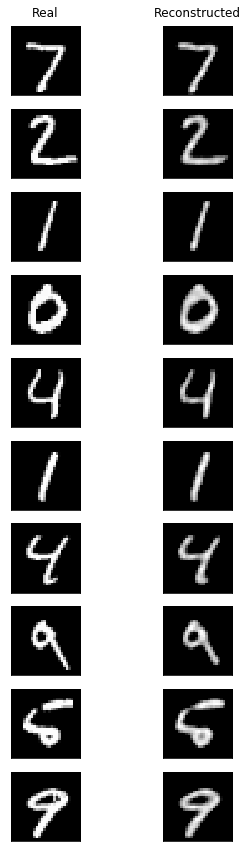

In [13]:
plot_images(disp_imgs, "Auto-encoder", images_to_plot)
plt.show()